In [1]:
import numpy as np
import pandas as pd
import os

import sklearn.linear_model
import sklearn.pipeline
import sklearn.metrics

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt

In [2]:
x_train_N = np.load("data_reviews/x_train_BERT_embeddings.npy")
y_train_N = pd.read_csv("data_reviews/y_train.csv").to_numpy()[:,0]

x_train_N, y_train_N = shuffle(x_train_N, y_train_N)

x_train_N.shape

(2400, 768)

In [3]:
def make_hyperparam_grid():

    hyperparam_grid = {}

    # hyperparam_grid["classifier__activation"] = ["identity", "logistic", "tanh", "relu"]
    # hyperparam_grid["classifier__solver"] = ["lbfgs", "sgd", "adam"]
    hyperparam_grid["classifier__alpha"] = np.logspace(-2, 2, 5)
    hyperparam_grid["classifier__hidden_layer_sizes"] = [(256,) * i for i in range(1, 6)]

    return hyperparam_grid

In [4]:
def make_classifier_pipeline(alpha=10.0, hidden_layer_sizes=(256, 256, 256)):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
            (
                "classifier",
                MLPClassifier(random_state=1, max_iter=100000, solver="adam", activation="relu", alpha=alpha, hidden_layer_sizes=hidden_layer_sizes),
            ),
        ]
    )

    return pipeline

In [5]:
alpha_values = np.logspace(-6, 6, 13)

x_valid = x_train_N[:480]
y_valid = y_train_N[:480]

x_train = x_train_N[480:]
y_train = y_train_N[480:]

In [6]:
tr_err_for_alpha = []
va_err_for_alpha = []

for alpha in alpha_values:
    curr_pipeline = make_classifier_pipeline(alpha=alpha)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_alpha.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_alpha.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))

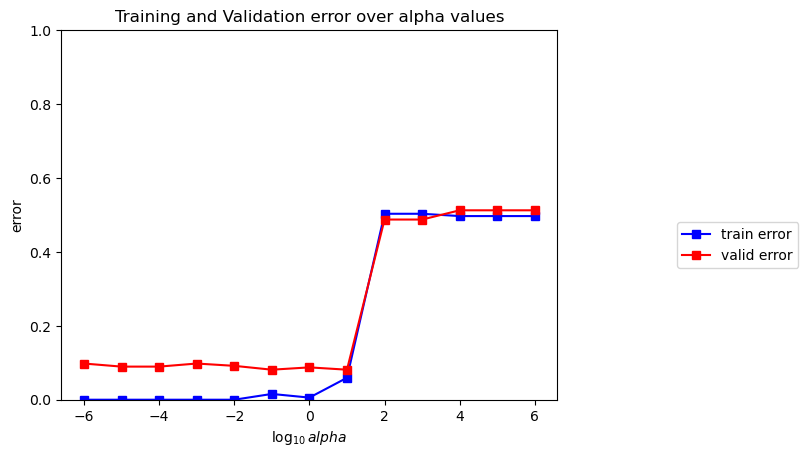

In [7]:
plt.title("Training and Validation error over alpha values");
plt.plot(np.log10(alpha_values), tr_err_for_alpha, 'bs-', label='train error')
plt.plot(np.log10(alpha_values), va_err_for_alpha, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("$\log_{10} alpha$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

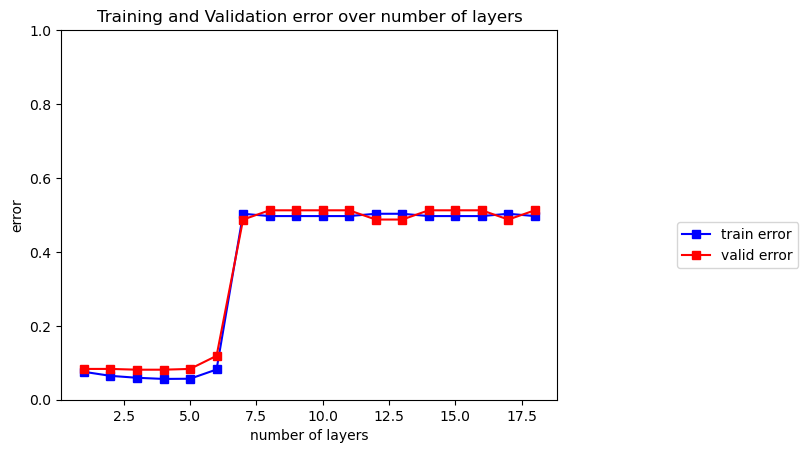

In [8]:
number_layers = [(256,)*i for i in range(1,19)]

tr_err_for_layers = []
va_err_for_layers = []

for layer in number_layers:
    curr_pipeline = make_classifier_pipeline(hidden_layer_sizes=layer)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_layers.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_layers.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))

    
plt.title("Training and Validation error over number of layers");
plt.plot([i for i in range(1,19)], tr_err_for_layers, 'bs-', label='train error')
plt.plot([i for i in range(1,19)], va_err_for_layers, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("number of layers");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

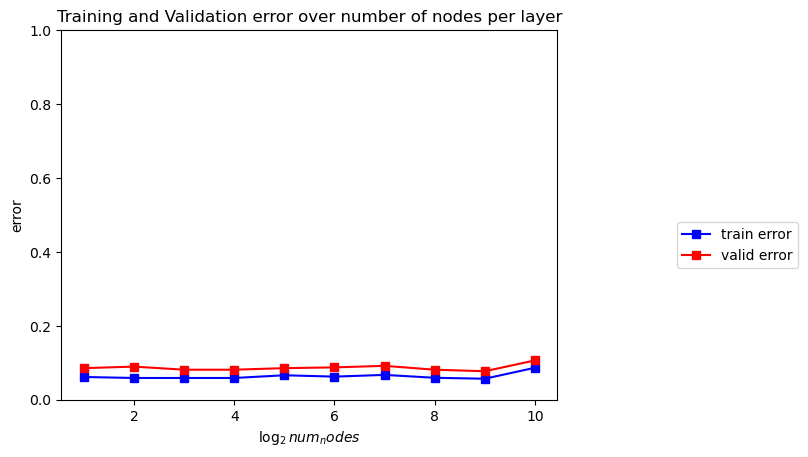

In [9]:
arr = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

number_nodes = [(elem,)*3 for elem in arr]

tr_err_for_nodes = []
va_err_for_nodes = []

for nodes in number_nodes:
    curr_pipeline = make_classifier_pipeline(hidden_layer_sizes=nodes)
    curr_pipeline.fit(x_train, y_train)

    yhat_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_valid = curr_pipeline.predict_proba(x_valid)[:,1]
    
    tr_err_for_nodes.append(sklearn.metrics.zero_one_loss(y_train, yhat_train >= 0.5))
    va_err_for_nodes.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid >= 0.5))

    
plt.title("Training and Validation error over number of nodes per layer");
plt.plot(np.log2(arr), tr_err_for_nodes, 'bs-', label='train error')
plt.plot(np.log2(arr), va_err_for_nodes, 'rs-', label='valid error')

plt.ylabel('error')
plt.xlabel("$\log_{2} num_nodes$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

In [10]:
print(number_nodes)

[(2, 2, 2), (4, 4, 4), (8, 8, 8), (16, 16, 16), (32, 32, 32), (64, 64, 64), (128, 128, 128), (256, 256, 256), (512, 512, 512), (1024, 1024, 1024)]


In [11]:
pipeline = make_classifier_pipeline()
hyperparam_grid = make_hyperparam_grid()

grid_searcher = sklearn.model_selection.GridSearchCV(
    pipeline,
    hyperparam_grid,
    cv=5,
    scoring="roc_auc"
)

In [63]:
yhat_proba_valid = pipeline.predict_proba(x_valid)[:,1]
thresholds_va = np.linspace(0, 1, 101)
accuracies = [sklearn.metrics.accuracy_score(y_valid, yhat_proba_valid >= thres) for thres in thresholds_va]

max_acc_threshold = thresholds_va[accuracies.index(max(accuracies))]

yhat_valid = (yhat_proba_valid >= max_acc_threshold).astype(int)

confusion_matrix = sklearn.metrics.confusion_matrix(y_valid, yhat_valid)
print(confusion_matrix)

[[233  13]
 [ 15 219]]


In [62]:
yhat_valid = yhat_proba_valid >= max_acc_threshold

false_positive_indices = [yhat_valid[i] == 1 and y_valid[i] == 0 for i in range(len(y_valid))]
false_negative_indices = [yhat_valid[i] == 0 and y_valid[i] == 1 for i in range(len(y_valid))]

false_positives = x_valid[false_positive_indices]
false_negatives = x_valid[false_negative_indices]

print(len(false_positives))
print(len(false_negatives))

print(false_positives)
print(false_negatives)

13
15
[[ 0.23951192 -0.24664576 -0.2127794  ... -0.11542743  0.25820023
   0.55111045]
 [-0.08975307 -0.10761841 -0.30567712 ... -0.49351007  0.30512953
   0.48230964]
 [-0.07706162  0.11357196  0.36537972 ... -0.41700935  0.35962224
  -0.04974935]
 ...
 [-0.23799938  0.373094   -0.15886968 ... -0.04035165  0.08515267
   0.48189697]
 [ 0.02384302  0.16156013  0.09267634 ... -0.12905277  0.0837738
   0.45618844]
 [ 0.22852731  0.20609653  0.27584174 ... -0.32737637  0.39279237
   0.27326494]]
[[-0.01226041 -0.13501707 -0.05626567 ... -0.22490151  0.0899018
   0.41407177]
 [-0.01646946 -0.28826052 -0.03780225 ...  0.19748823  0.23308112
   0.6867998 ]
 [-0.13885932  0.06245282 -0.37875193 ... -0.2950764   0.46875906
   0.58230567]
 ...
 [ 0.13498236 -0.3793377  -0.24817581 ... -0.06257502  0.23564604
   0.3102354 ]
 [-0.12605858  0.1722309   0.03111582 ... -0.02149836  0.55927444
   0.30694994]
 [ 0.06077665  0.151004   -0.40410072 ... -0.13945054  0.14426781
   0.48389602]]


In [61]:
x_train_N = np.load("data_reviews/x_train_BERT_embeddings.npy")
y_train_N = pd.read_csv("data_reviews/y_train.csv").to_numpy()[:,0]

original_indices = np.arange(len(x_train_N))

x_train_N, y_train_N, original_indices = shuffle(x_train_N, y_train_N, original_indices)

x_train_reviews = pd.read_csv("data_reviews/x_train.csv").to_numpy()[:,0]

false_positive_original_indices = original_indices[np.where(false_positive_indices)[0]]
false_negative_original_indices = original_indices[np.where(false_negative_indices)[0]]

false_positive_reviews = x_train_reviews[false_positive_original_indices]
false_negative_reviews = x_train_reviews[false_negative_original_indices]

print("False Positive Reviews:")
for i, review in enumerate(false_positive_reviews, 1):
    print(f"{i}. {review}\n")

print("False Negative Reviews:")
for i, review in enumerate(false_negative_reviews, 1):
    print(f"{i}. {review}\n")

False Positive Reviews:
1. imdb

2. amazon

3. imdb

4. amazon

5. imdb

6. imdb

7. amazon

8. amazon

9. amazon

10. imdb

11. imdb

12. amazon

13. imdb

False Negative Reviews:
1. imdb

2. yelp

3. yelp

4. yelp

5. yelp

6. yelp

7. yelp

8. yelp

9. amazon

10. amazon

11. amazon

12. imdb

13. yelp

14. amazon

15. yelp



In [60]:
x_train_text_reviews = pd.read_csv("data_reviews/x_train.csv").to_numpy()[:,1]

false_positive_text_reviews = x_train_text_reviews[false_positive_original_indices]
false_negative_text_reviews = x_train_text_reviews[false_negative_original_indices]

print("False Positive Reviews:")
for i, review in enumerate(false_positive_text_reviews, 1):
    print(f"{i}. {review}\n")

print("False Negative Reviews:")
for i, review in enumerate(false_negative_text_reviews, 1):
    print(f"{i}. {review}\n")

False Positive Reviews:
1. Nothing new there.  

2. This wonderful experience made this place a must-stop whenever we are in town again.

3. Then I had to continue pairing it periodically since it somehow kept dropping.

4. The burger... I got the "Gold Standard" a $17 burger and was kind of disappointed.

5. My sashimi was poor quality being soggy and tasteless.

6. Everything Captain Howdy says is either laughable or just plain stupid.  

7. Battery life is real good.

8. The chicken was deliciously seasoned and had the perfect fry on the outside and moist chicken on the inside.

9. The staff is great, the food is delish, and they have an incredible beer selection.

10. It is shameful.  

11. Easy to pair with my Samsung Cell.

12. I have 2-3 bars on my cell phone when I am home, but you cant not hear anything.

13. Nothing at all to recommend.  

False Negative Reviews:
1. The awful dialogue and hopeless overacting by everyone who gets shot top off a real waste of space and time.  


In [14]:
grid_searcher.fit(x_train_N, y_train_N)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        MLPClassifier(alpha=10.0,
                                                      hidden_layer_sizes=(256,
                                                                          256,
                                                                          256),
                                                      max_iter=100000,
                                                      random_state=1))]),
             param_grid={'classifier__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'classifier__hidden_layer_sizes': [(256,), (256, 256),
                                                            (256, 256, 256),
                                                            (256, 256, 256,
                                                             256),
                                                            (256, 256, 256, 256,
                                                             256)]},
             scoring='roc_auc')

In [16]:
print(f"best score: {grid_searcher.best_score_}")
print("best params:", grid_searcher.best_params_)

best score: 0.9686111111111112
best params: {'classifier__alpha': 10.0, 'classifier__hidden_layer_sizes': (256, 256)}


In [17]:
pd.DataFrame(grid_searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.960939,0.426811,0.002556,0.001001,0.01,"(256,)","{'classifier__alpha': 0.01, 'classifier__hidde...",0.964245,0.952066,0.955052,0.971771,0.976632,0.963953,0.009407,11
1,2.781609,0.094047,0.004438,0.001305,0.01,"(256, 256)","{'classifier__alpha': 0.01, 'classifier__hidde...",0.962708,0.952352,0.951571,0.971181,0.975486,0.962660,0.009657,17
2,4.191417,0.376017,0.004437,0.002111,0.01,"(256, 256, 256)","{'classifier__alpha': 0.01, 'classifier__hidde...",0.962413,0.950599,0.954861,0.968021,0.973255,0.961830,0.008293,18
3,6.179802,0.826158,0.004443,0.001589,0.01,"(256, 256, 256, 256)","{'classifier__alpha': 0.01, 'classifier__hidde...",0.960469,0.951189,0.951649,0.964957,0.973550,0.960363,0.008427,20
4,8.683480,1.214063,0.006507,0.002679,0.01,"(256, 256, 256, 256, 256)","{'classifier__alpha': 0.01, 'classifier__hidde...",0.959505,0.949054,0.949523,0.970417,0.978168,0.961333,0.011485,19
5,7.373780,1.018978,0.002591,0.001153,0.1,"(256,)","{'classifier__alpha': 0.1, 'classifier__hidden...",0.964410,0.951771,0.955608,0.972969,0.976441,0.964240,0.009540,10
6,6.614110,0.805992,0.002419,0.000186,0.1,"(256, 256)","{'classifier__alpha': 0.1, 'classifier__hidden...",0.961658,0.957205,0.956285,0.971319,0.972344,0.963762,0.006842,14
7,14.846620,4.505427,0.003654,0.000793,0.1,"(256, 256, 256)","{'classifier__alpha': 0.1, 'classifier__hidden...",0.967604,0.957847,0.956059,0.972708,0.973420,0.965528,0.007305,7
8,14.305755,4.630456,0.005149,0.003336,0.1,"(256, 256, 256, 256)","{'classifier__alpha': 0.1, 'classifier__hidden...",0.969149,0.959427,0.953663,0.969132,0.975365,0.965347,0.007755,9
9,14.103827,3.253267,0.006428,0.002175,0.1,"(256, 256, 256, 256, 256)","{'classifier__alpha': 0.1, 'classifier__hidden...",0.962691,0.949635,0.956892,0.971649,0.974809,0.963135,0.009276,16


In [18]:
x_test_N = np.load("data_reviews/x_test_BERT_embeddings.npy")

model = grid_searcher.best_estimator_

predictions = model.predict_proba(x_test_N)[:,1]

np.savetxt("yproba1_test.txt", predictions)